<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорты-и-загрузка" data-toc-modified-id="Импорты-и-загрузка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорты и загрузка</a></span></li><li><span><a href="#Обзор" data-toc-modified-id="Обзор-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обзор</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#LGBMRClassifier" data-toc-modified-id="LGBMRClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBMRClassifier</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорты и загрузка

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import re

from catboost import CatBoostClassifier
from numpy.random import RandomState
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')   
nltk.download('omw-1.4')   
nltk.download('punkt') 
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Сделаем настройки

# Зададим формат отображения вещественных чисел в Pandas
pd.set_option('display.float_format', '{:,.2f}'.format)

# Сбросим ограничение на число столбцов
pd.set_option('display.max_columns', None)

# Сбросим ограничение на число строк
pd.set_option('display.max_rows', None)

# Не показываем предупреждения
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Зададим константу для генератора псевдослучайных чисел
RANDOM_STATE = 42

# Зададим значение для генератора псевдослучайных чисел
np.random.seed(RANDOM_STATE)

In [3]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=['Unnamed: 0'])
except:
    df = pd.read_csv('toxic_comments.csv', index_col=['Unnamed: 0'])

### Обзор

In [4]:
# посмотрим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Взглянем на соотношение токсичных комментариев к неитральным. Отобразим гистограмму.

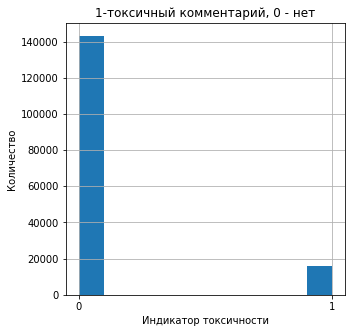

In [6]:
plt.figure(figsize=(5, 5))
df['toxic'].hist()
plt.xticks([0, 1])
plt.title('1-токсичный комментарий, 0 - нет')
plt.ylabel('Количество')
plt.xlabel('Индикатор токсичности');

In [7]:
# Выведем процентное соотношение
df['toxic'].value_counts(normalize=True)

0   0.90
1   0.10
Name: toxic, dtype: float64

In [8]:
# Проверим наличие явных дубликатов
df.duplicated().sum()

0

In [9]:
# Неявных
df['text'].duplicated().sum()

0

В таблице нет пропусков и дубликатов. \
Случаи содержат знаки препинания, разделители строк, цифры, разных регистр. \
Приведем текст комментариев к нижнему регистру, очистим от не алфавитных символов, токенизируем, приведем слова комментариев к начальной форме - лемме, сформируем корпус, уберем стоп-слова и векторизируем текст. 

### Подготовка

In [10]:
# Приведем к нижнему регистру
df['text'] = df['text'].apply(str.lower)

# Очистим от лишних символов
df['text'] = df['text'].apply(lambda x: re.sub(r'\W', ' ', x))

# Токенизируем текст
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x, language="english"))

Так как у нас английские посты, будем использовать не разработку Яндекса - Mystem, а WordNetLemmatizer, он обеспечивает хорошую лемматизацию для английских слов.

In [11]:
%%time

def get_wordnet_pos(word):
    """Функция для нахождения корректного POS-тега."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


lemmatizer = WordNetLemmatizer()

df['text'] = df['text'].apply(lambda text: ' '.join(
    lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text
))

df.head()

CPU times: user 16min 13s, sys: 1min 24s, total: 17min 37s
Wall time: 17min 38s


,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


Разделим датафрейм на обучающую и тестовые выборки.

In [12]:
features_train, features_test, target_train, target_test = train_test_split(
    df['text'], df['toxic'], test_size=0.2, random_state=RANDOM_STATE
)

print(f'Размер обучающей выборки - {features_train.shape}.')
print(f'Размер тестовой выборки - {features_test.shape}.')

Размер обучающей выборки - (127433,).
Размер тестовой выборки - (31859,).


Преобразуем текстовые данные в матрицу, используя метод TF-IDF (Term Frequency-Inverse Document Frequency).  \
Также удалим стоп-слова (артикли, междометия, союзы и т.д., которые не несут смысловой нагрузки). При применении алгоритмов машинного обучения такие слова могут добавить много шума, поэтому сразу избавимся и от них. 

## Обучение

Перед нами стоит задача бинарной классификации, поэтому обучим несколько моделей: Логистическую регрессию, CatBoostClassifier, LGBMRClassifier.

### Линейная регрессия

In [14]:
%%time

stopwords = set(nltk_stopwords.words('english'))

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("model", LogisticRegression(solver='liblinear')),
    ]
)

params_lreg = {'model__penalty': ['l1', 'l2'],
               'model__max_iter': (100, 200),}

grid_search = GridSearchCV(pipeline,
                           params_lreg,
                           cv=3,
                           scoring='f1')

grid_search.fit(features_train,
                target_train)

f'Лучшие параметры: {grid_search.best_params_}'

CPU times: user 1min 39s, sys: 25.4 s, total: 2min 4s
Wall time: 2min 5s


"Лучшие параметры: {'model__max_iter': 100, 'model__penalty': 'l1'}"

In [15]:
# сохраним метрику f1
f1_lreg = grid_search.best_score_

# сохраним экземпляр лучшей модели
best_model_lreg = grid_search.best_estimator_

f'Наилучшая оценка модели: {f1_lreg:.2f}'

'Наилучшая оценка модели: 0.77'

### CatBoostClassifier

In [16]:
%%time

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("model", CatBoostClassifier(learning_rate=0.1,
                                     loss_function='Logloss',
                                     verbose=False)),
    ]
)

param_grid = {'model__depth': [2, 4],
              'model__iterations': [50, 100]}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs = -1,
    scoring='f1'
)

grid_search.fit(features_train, target_train)

CPU times: user 17min 11s, sys: 8.19 s, total: 17min 19s
Wall time: 17min 27s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
          

In [17]:
features_train.head()

45208    you claimed to have scavenge the un and ngo we...
60971    please do not vandalize page a you do with thi...
92333          large moon shouldn t it say large know moon
74833    isn t baking cooking accord to the article app...
7210     i be sure the judge smile too when you conside...
Name: text, dtype: object

In [18]:
f'Наилучшие значения параметров: {grid_search.best_params_}'

"Наилучшие значения параметров: {'model__depth': 4, 'model__iterations': 100}"

In [19]:
f1_cat = grid_search.best_score_
best_model_cat = grid_search.best_estimator_
f'Наилучшая оценка модели: {f1_cat:.2f}'

'Наилучшая оценка модели: 0.62'

### LGBMRClassifier

In [20]:
%%time

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("model", LGBMClassifier(objective='binary',
                                 metric='binary_logloss',
                                 learning_rate=0.1,
                                 verbose=0,
                                 force_row_wise=True)),
    ]
)

param_grid = {'model__max_depth': [2, 4],
              'model__n_estimators': [50, 100]}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs = -1,
    scoring='f1'
)

grid_search.fit(features_train, target_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
          

In [21]:
f'Наилучшие значения параметров: {grid_search.best_params_}'

"Наилучшие значения параметров: {'model__max_depth': 4, 'model__n_estimators': 100}"

In [22]:
f1_light = grid_search.best_score_
best_model_light = grid_search.best_estimator_
f'Наилучшая оценка модели: {f1_light:.2f}'

'Наилучшая оценка модели: 0.62'

Подытожим:

In [23]:
table = pd.DataFrame(index = ['Линейная регрессия', 'LightGBM', 'Catboost'],
                     columns=['F1 score'],
                     data=[[f1_lreg],
                           [f1_light],
                           [f1_cat]])
table

,F1 score
Линейная регрессия,0.77
LightGBM,0.62
Catboost,0.62


Таким образом, лучшие результаты показала Линейная регрессия. Протестируем ее на тестовой выборке. 

### Тестирование

In [24]:
preds = best_model_lreg.predict(features_test)

rmse_light = f1_score(target_test, preds)

f'F1 модели Линейной регрессии на тестовой выборке: {rmse_light:.2f}'

'F1 модели Линейной регрессии на тестовой выборке: 0.77'

На тестовой выборке модель показала себя также хорошо, как и на кросс-валидационных выборках. 

## Выводы

Нам необходимо было решить задачу бинарной классификации комментариев для интернет-магазина 'Викишоп', нужно было подготовить данные, обучить и протестировать несколько моделей. \
Была задача получить значение метрики качества F1 не менее 0.75. \
В ходе данной работы и ознакомились с данными, провели подготовку и деление на обучающие и тестовые выборки, обучили три модели: Линейную регрессию, LGBMClassifier и CatBoostClassifier, которые показали следующие результаты:

In [25]:
table

,F1 score
Линейная регрессия,0.77
LightGBM,0.62
Catboost,0.62


Лучшие результаты показала модель Линейной регрессии, метрика F1 которой составила 0.76. \
Данную модель мы протестировали на тестовой выборке, на которой модель показала результат такой же, как и на кросс-валидационных выборках.